# TODO:

0) Fix colors to be consistent when num of langs is smaller

1) Try another implementations for metrics / implement myself / with students

https://github.com/majedelhelou/AL2/blob/e0c796d9145407335fd757e53ce651118bfde21f/code/evaluate.py#L50

2) try another value of K for SVCCA

3) try another implementation of PWCCA and compare that with google's

4) make my own PWCCA

5) IMPORtant: plot variance graphs for svcca for all lang pairs (as in tutorial) and find threashold

# TODO2:
* add attentions comaprioson! (just at some point at the end of the paper)
* for this just extract them from all layers, flatten the same way, and apply CKA!

In [1]:
# load the needed extension for the %%R cell magic
%load_ext rpy2.ipython

In [1]:
%load_ext autoreload
%autoreload 2
%load_ext rpy2.ipython
%matplotlib inline

In [3]:
import os
os.chdir('..')  # navigate to the root
from normal_transformers.util.util_common import pickle_load_from_file

In [4]:
from rpy2 import robjects
from rpy2.robjects import Formula, Environment
from rpy2.robjects.vectors import IntVector, FloatVector
from rpy2.robjects.lib import grid
from rpy2.robjects.packages import importr, data
from rpy2.rinterface_lib.embedded import RRuntimeError
import warnings

# The R 'print' function
rprint = robjects.globalenv.find("print")
stats = importr('stats')
grdevices = importr('grDevices')
base = importr('base')
datasets = importr('datasets')

grid.activate()

# plotting
import pandas as pd
import rpy2
import csv

from rpy2.robjects.lib import grdevices
from rpy2.robjects.vectors import IntVector, FloatVector
from IPython.display import Image, display

from rpy2.robjects import pandas2ri
pandas2ri.activate()

import rpy2.robjects as robjects
from rpy2.robjects.lib import grdevices
from rpy2.robjects.vectors import IntVector, FloatVector
from IPython.display import Image, display

import rpy2.robjects.packages as packages
import rpy2.robjects.lib.ggplot2 as ggplot2
import rpy2.robjects as ro

from rpy2.robjects.packages import STAP
with open('examples/theme_publication_tartunlp.R', 'r') as f:
    string = f.read()
pub_theme = STAP(string, "pub_theme")

In [5]:
graphics = ro.packages.importr('graphics')
r_utils = ro.packages.importr('utils')
# r_utils.install_packages("ggthemes")
ggthemes = ro.packages.importr('ggthemes')

In [6]:
#r_utils.remove_packages('ggthemes')

In [7]:
model_names_mapping = {
    "xlm-roberta-large": "XLM-R_large",
    "xlm-roberta-base": "XLM-R_base",
    "bert-base-multilingual-cased": "mBERT_cased",
    "bert-base-multilingual-uncased": "mBERT_uncased",
    "distilbert-base-multilingual-cased": "distil_mBERT",
    "xlm-mlm-100-1280": "XLM-MLM_100"
}
    

In [8]:
savedir_base = f"experiments/assets/multilingual"

# Util

In [166]:
def load_sim_scores_csv(model_name_or_dir, data_type, sim_name, sent_rep_type, lang_pairs):
    loaddir = f"{savedir_base}/{model_name_or_dir}/sim_scores"
    sim_scores_dict = {}
    for lang_pair in lang_pairs:
        fn = f"{data_type}_{sim_name}_{sent_rep_type}_{lang_pair}.csv"
        
        try:
            with open(f'{loaddir}/{fn}') as csvfile:
                scores = [float(s) for s in list(csv.reader(csvfile))[0]]
                sim_scores_dict[lang_pair] = scores
        except:
            pass

    return sim_scores_dict

In [167]:
def load_sim_scores_into_df(model_name_or_dir, data_type, sim_names, sent_rep_type, lang_pairs, lang_pairs_exclude=[]):
    # load metrics data
    sim_scores_all_metrics = {} 
    for sim_name in sim_names:
        scores = load_sim_scores_csv(
                                model_name_or_dir, 
                                data_type, sim_name, 
                                sent_rep_type, 
                                lang_pairs)
        
        for lpair in lang_pairs_exclude:
            del scores[lpair]

        # TODO: remove ugly hack; just remove 0s entry from all 13 layer files!
        for k, v in scores.items():
            if len(v) == 13:
                scores[k] = v[1:]

        sim_scores_all_metrics[sim_name] = scores
        
    
    dict_of_sim_scors_dicts = sim_scores_all_metrics
    # craft padnas dataframe from it
    list_of_dfs = []
    for sim_name, sim_scores_dict in dict_of_sim_scors_dicts.items():
        tmp = {str(k).replace("-", "_"): v for k, v in sim_scores_dict.items()}
        sim_scores = tmp
        del tmp

        sim_scores_df = pd.DataFrame.from_dict(sim_scores)
        sim_scores_df["Layer"] = [i+1 for i in range(len(sim_scores_df))]
        sim_scores_df["Similarity"] = [str(sim_name) for i in range(len(sim_scores_df))]

        lang_pair_names = [v for v in sim_scores_df.columns.values if v != "Layer" and v != "Similarity"]
        sim_scores_df = pd.melt(sim_scores_df, id_vars=["Layer", "Similarity"], value_vars=lang_pair_names,
                               var_name='lang_pair', value_name="Score")

        sim_scores_df = sim_scores_df.astype({"Layer": int})
        list_of_dfs.append(sim_scores_df)
    
    final_df = pd.concat(list_of_dfs, ignore_index=True) 
    
    return final_df

    

In [174]:
def ggplot2_plot_lines(df, title):
    gp = ggplot2.ggplot(sim_scores_df)

    pp = gp \
    + ggplot2.aes_string(x='Layer', y='Score') \
    + ggplot2.ggtitle(title) \
    + ggplot2.geom_line(ggplot2.aes_string(color = "lang_pair")) \
    + ggplot2.ylim(0, 1) \
    + ggplot2.facet_grid(ro.Formula('. ~ Similarity')) \
    + pub_theme.theme_Publication() \
    + ggplot2.scale_fill_manual(values=["#7268D8", "#E0B12B", "#EF6650", "#4DB6AC", "#3185FF", "#3195FF"]) \
    + ggplot2.scale_x_continuous(labels = sim_scores_df["Layer"], breaks = sim_scores_df["Layer"])

    return pp
    #pp.plot()

#  1. Step 1: Influence of metrics

# CLS reps at all layer? Lets look at all metrics

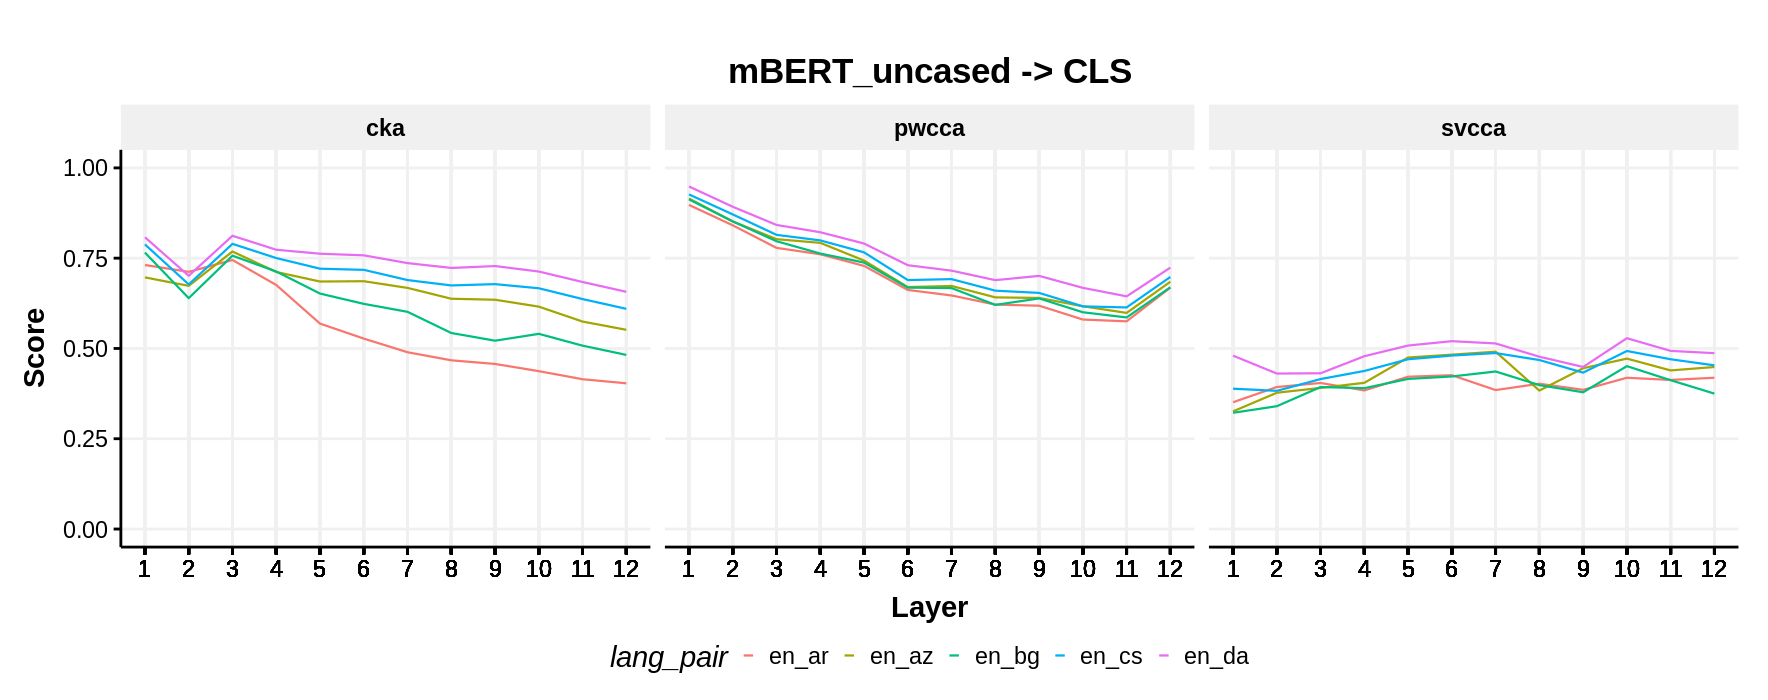

In [175]:
# GLOBALS
model_name_or_dir = "bert-base-multilingual-uncased"
data_type = "xnli6"
sent_rep_type = "cls"
sim_names = ["pwcca", "cka", "svcca"]
lang_pairs = ["en-ar", "en-az", "en-bg", "en-cs", "en-da", "en-en_shuf"]
skip_0_layer = True
# load df

sim_scores_df = load_sim_scores_into_df(
    model_name_or_dir=model_name_or_dir, 
    data_type=data_type, 
    sim_names=sim_names, 
    sent_rep_type=sent_rep_type, 
    lang_pairs=lang_pairs,
    lang_pairs_exclude=["en-en_shuf"])

# plot metrics data
with grdevices.render_to_bytesio(grdevices.png, width=1768, height=700, res=150) as img:
    title = f"{model_names_mapping[model_name_or_dir]} -> {sent_rep_type.upper()}"
    plot = ggplot2_plot_lines(sim_scores_df, title)
    plot = plot
    plot.plot()
display(Image(data=img.getvalue(), format='png', embed=True))

* We reproduced Singh results with pwcca and CKA; SVCCA need hyperparams
* However CLS as sent rep is not good
* also not that PWCCA does not deal with baseline good, so cannot be trusted probaby!
* while SVCCA is very sensible to hparams! this is SVCCA10 
* tell we will come back to SVCCA next
* probably move SVCCA (and CCA?) to the end, do fine-tuning to it, and think if we can connect it to our error analysis!
* CCA (SVCCA?) absolute vlue decreases with the number of datapoints

# Let's see the change for mean representations!

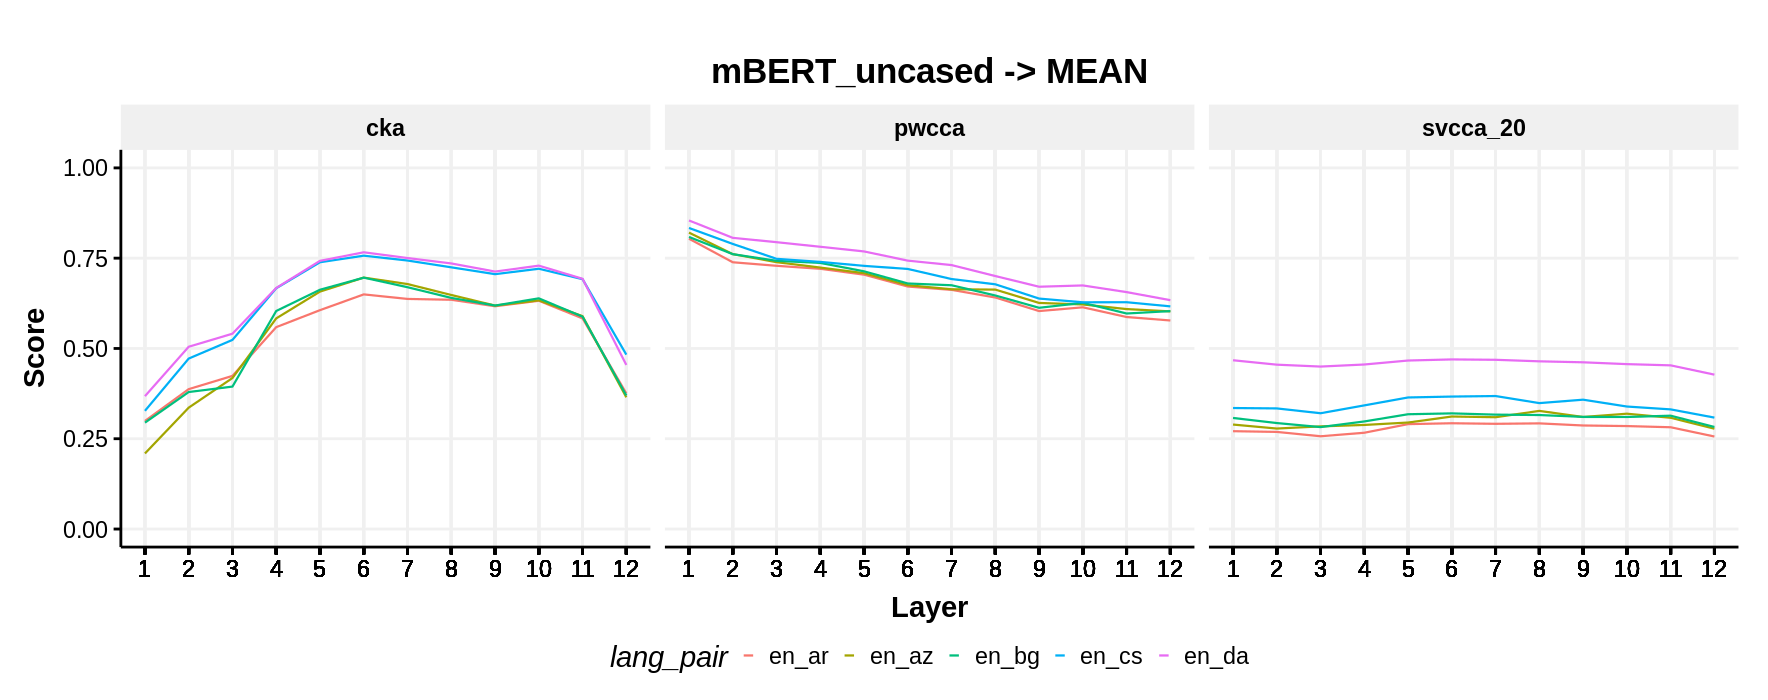

In [119]:
# GLOBALS
model_name_or_dir = "bert-base-multilingual-uncased"
data_type = "xnli6"
sent_rep_type = "mean"
sim_names = ["pwcca", "cka", "svcca_20"]
lang_pairs = ["en-ar", "en-az", "en-bg", "en-cs", "en-da", "en-en_shuf"]
skip_0_layer = True
# load df

sim_scores_df = load_sim_scores_into_df(
    model_name_or_dir=model_name_or_dir, 
    data_type=data_type, 
    sim_names=sim_names, 
    sent_rep_type=sent_rep_type, 
    lang_pairs=lang_pairs,
    lang_pairs_exclude=["en-en_shuf"])

# plot metrics data
with grdevices.render_to_bytesio(grdevices.png, width=1768, height=700, res=150) as img:
    title = f"{model_names_mapping[model_name_or_dir]} -> {sent_rep_type.upper()}"
    plot = ggplot2_plot_lines(sim_scores_df, title)
    plot = plot
    plot.plot()
display(Image(data=img.getvalue(), format='png', embed=True))

* Now we have the result for CKA! 
* However PWCCA and SVCCA are still broken, let's see how reliable it is for our task by adding permutation baseline

# Sanity check for metrics

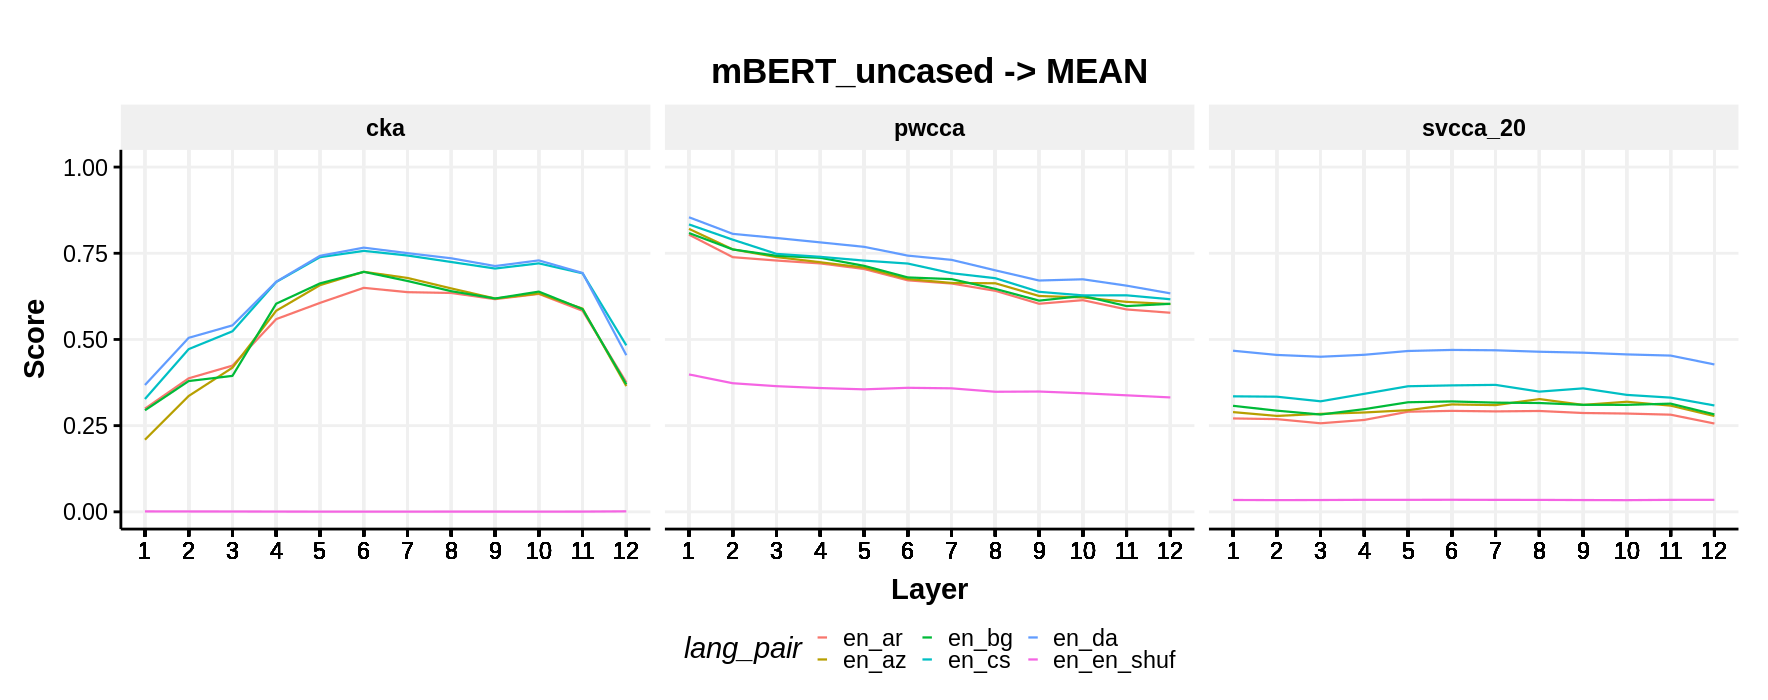

In [118]:
# GLOBALS
model_name_or_dir = "bert-base-multilingual-uncased"
data_type = "xnli6"
sent_rep_type = "mean"
sim_names = ["pwcca", "cka", "svcca_20"]
lang_pairs = ["en-ar", "en-az", "en-bg", "en-cs", "en-da", "en-en_shuf"]
skip_0_layer = True
# load df

sim_scores_df = load_sim_scores_into_df(
    model_name_or_dir=model_name_or_dir, 
    data_type=data_type, 
    sim_names=sim_names, 
    sent_rep_type=sent_rep_type, 
    lang_pairs=lang_pairs,
    #lang_pairs_exclude=["en-en_shuf"]
)

# plot metrics data
with grdevices.render_to_bytesio(grdevices.png, width=1768, height=700, res=150) as img:
    title = f"{model_names_mapping[model_name_or_dir]} -> {sent_rep_type.upper()}"
    plot = ggplot2_plot_lines(sim_scores_df, title)
    plot = plot
    plot.plot()
display(Image(data=img.getvalue(), format='png', embed=True))

CKA: passes the check nicely!

PWCCA:
* We see that pwcca gives lower, but still quite big score for the permutation baseline
* What is more important, it gives this random pattern similar shape, which further suggests that this metric might not be a good fit if it is interested in pattern
* It does the job of separating things, but not further
* Is it because the projection that we use to weight cca results removes imprtant information about the task? Check what invariance is added!!! This invariance probably contains the pattern iteself then!
* Also check cca, since it is the 1st step

SVCCA:
* passes the check nicely, but does not reveal the pattern
* what if we have chosen the wrong number of coefs?
* lets take 20 instead of 10

# What if we encode one-sentence instead of 2?

# XLM-R

### One

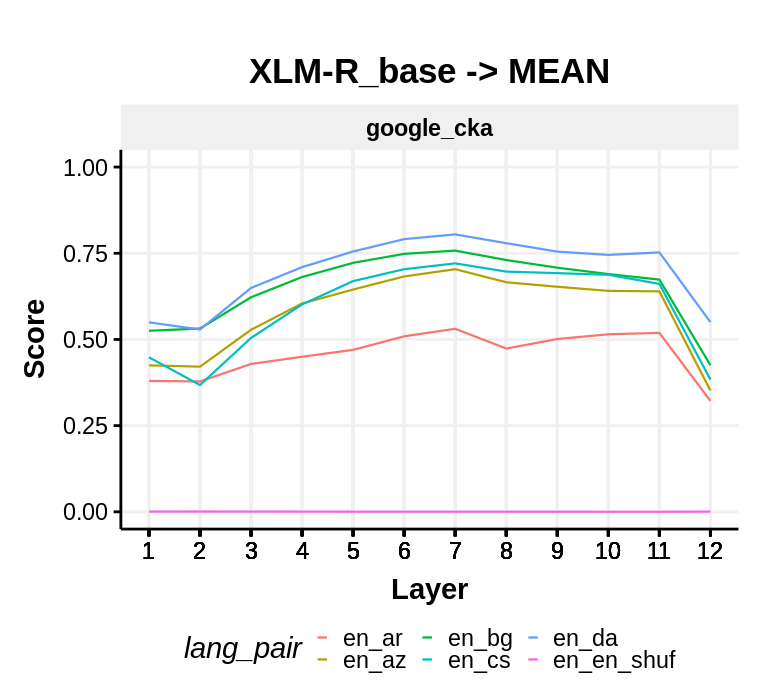

In [125]:
# GLOBALS
model_name_or_dir = "xlm-roberta-base"
data_type = "onlyhypo_xnli6"
sent_rep_type = "mean"
sim_names = ["google_cka"]
lang_pairs = ["en-en_shuf", "en-ar", "en-az", "en-bg", "en-cs", "en-da"]
skip_0_layer = True
# load df

sim_scores_df = load_sim_scores_into_df(
    model_name_or_dir=model_name_or_dir, 
    data_type=data_type, 
    sim_names=sim_names, 
    sent_rep_type=sent_rep_type, 
    lang_pairs=lang_pairs)

# plot metrics data
with grdevices.render_to_bytesio(grdevices.png, width=768, height=700, res=150) as img:
    title = f"{model_names_mapping[model_name_or_dir]} -> {sent_rep_type.upper()}"
    plot = ggplot2_plot_lines(sim_scores_df, title)
    plot = plot
    plot.plot()
display(Image(data=img.getvalue(), format='png', embed=True))

# SVCCA google

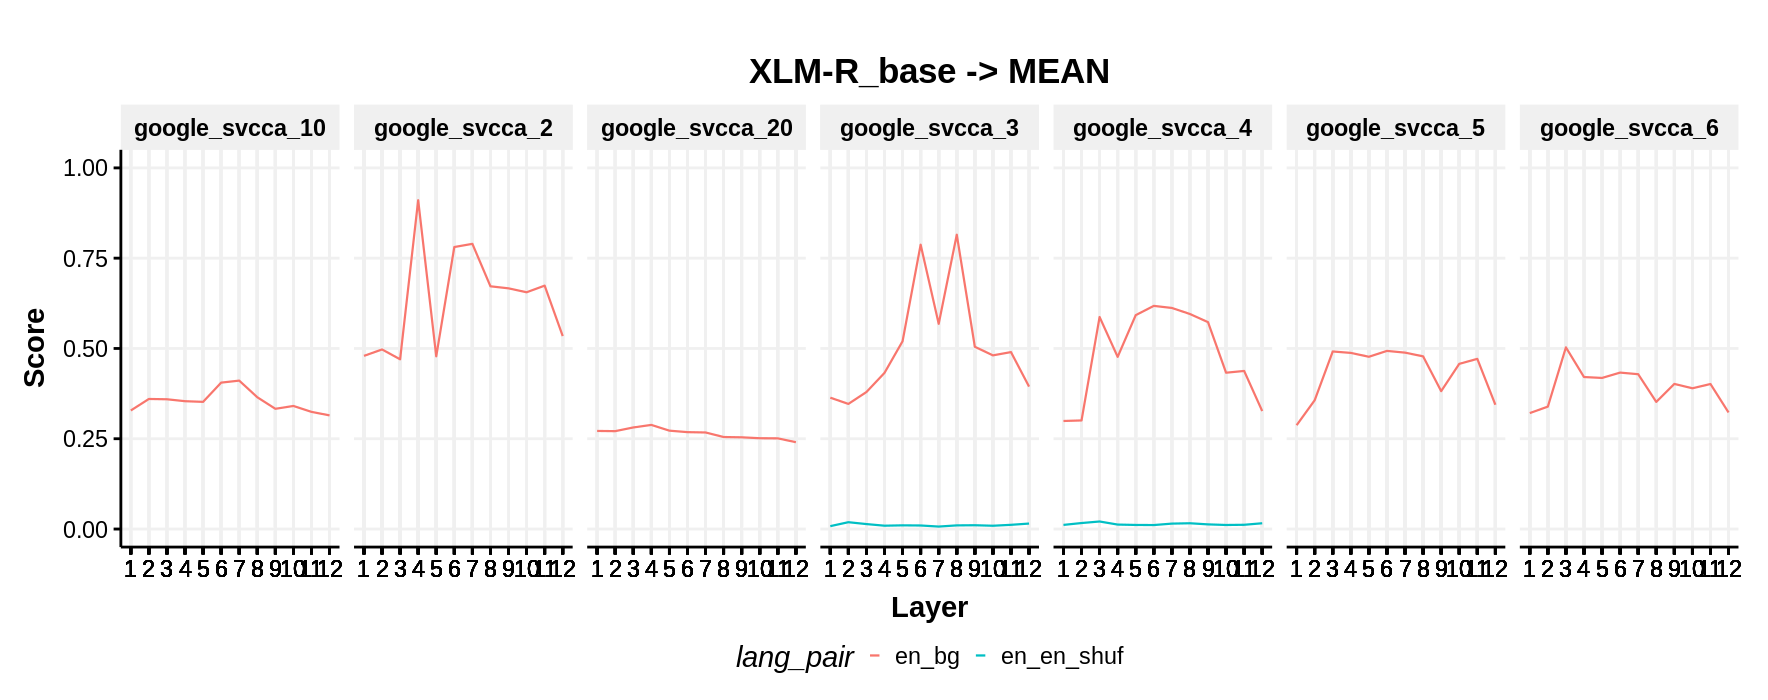

In [168]:
# GLOBALS
model_name_or_dir = "xlm-roberta-base"
data_type = "onlyhypo_xnli6"
sent_rep_type = "mean"
sim_names = ["google_svcca_10", "google_svcca_4", "google_svcca_5", "google_svcca_3", "google_svcca_6", "google_svcca_2", "google_svcca_20"]
lang_pairs = ["en-en_shuf", "en-ar", "en-az", "en-bg", "en-cs", "en-da"]
skip_0_layer = True
# load df

sim_scores_df = load_sim_scores_into_df(
    model_name_or_dir=model_name_or_dir, 
    data_type=data_type, 
    sim_names=sim_names, 
    sent_rep_type=sent_rep_type, 
    lang_pairs=lang_pairs)

# plot metrics data
with grdevices.render_to_bytesio(grdevices.png, width=1768, height=700, res=150) as img:
    title = f"{model_names_mapping[model_name_or_dir]} -> {sent_rep_type.upper()}"
    plot = ggplot2_plot_lines(sim_scores_df, title)
    plot = plot
    plot.plot()
display(Image(data=img.getvalue(), format='png', embed=True))

## SVCCA Anatome

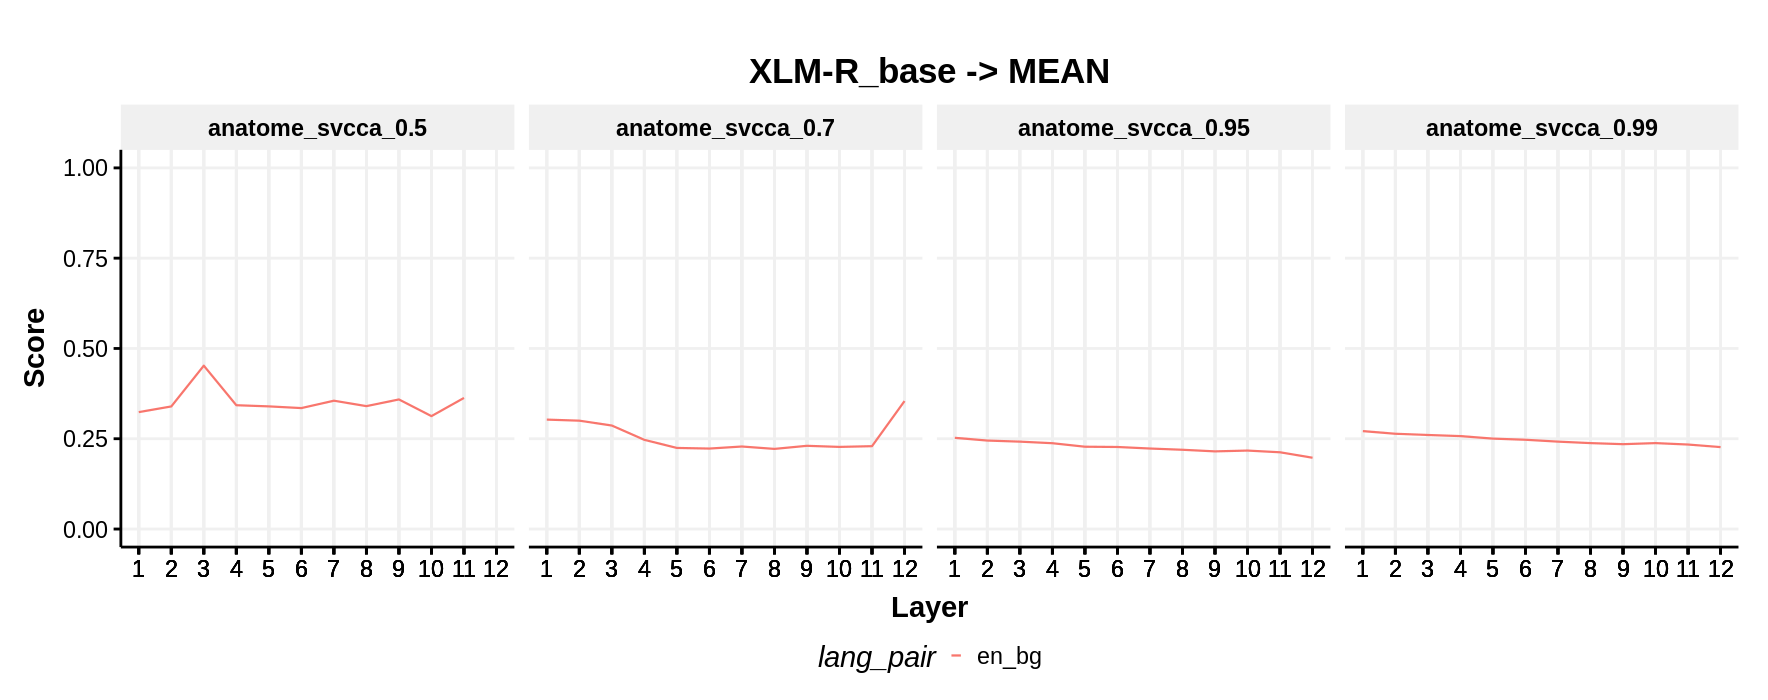

In [169]:
# GLOBALS
model_name_or_dir = "xlm-roberta-base"
data_type = "onlyhypo_xnli6"
sent_rep_type = "mean"
sim_names = ["anatome_svcca_0.99", "anatome_svcca_0.95", "anatome_svcca_0.7", "anatome_svcca_0.5"]
lang_pairs = ["en-en_shuf", "en-ar", "en-az", "en-bg", "en-cs", "en-da"]
skip_0_layer = True
# load df

sim_scores_df = load_sim_scores_into_df(
    model_name_or_dir=model_name_or_dir, 
    data_type=data_type, 
    sim_names=sim_names, 
    sent_rep_type=sent_rep_type, 
    lang_pairs=lang_pairs)

# plot metrics data
with grdevices.render_to_bytesio(grdevices.png, width=1768, height=700, res=150) as img:
    title = f"{model_names_mapping[model_name_or_dir]} -> {sent_rep_type.upper()}"
    plot = ggplot2_plot_lines(sim_scores_df, title)
    plot = plot
    plot.plot()
display(Image(data=img.getvalue(), format='png', embed=True))

# PWCCA

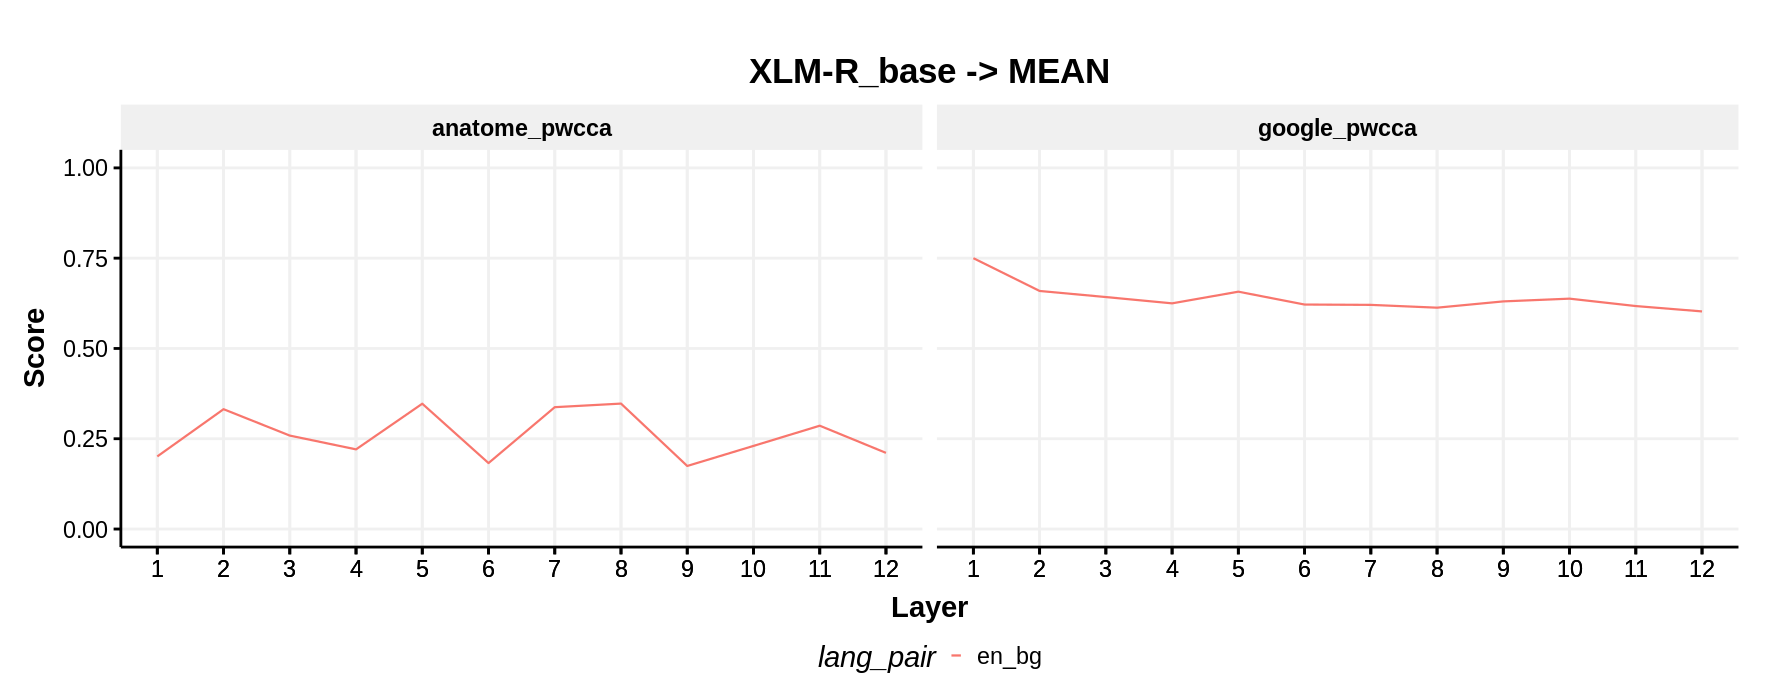

In [170]:
# GLOBALS
model_name_or_dir = "xlm-roberta-base"
data_type = "onlyhypo_xnli6"
sent_rep_type = "mean"
sim_names = ["google_pwcca", "anatome_pwcca"]
lang_pairs = ["en-en_shuf", "en-ar", "en-az", "en-bg", "en-cs", "en-da"]
skip_0_layer = True
# load df

sim_scores_df = load_sim_scores_into_df(
    model_name_or_dir=model_name_or_dir, 
    data_type=data_type, 
    sim_names=sim_names, 
    sent_rep_type=sent_rep_type, 
    lang_pairs=lang_pairs)

# plot metrics data
with grdevices.render_to_bytesio(grdevices.png, width=1768, height=700, res=150) as img:
    title = f"{model_names_mapping[model_name_or_dir]} -> {sent_rep_type.upper()}"
    plot = ggplot2_plot_lines(sim_scores_df, title)
    plot = plot
    plot.plot()
display(Image(data=img.getvalue(), format='png', embed=True))

### Two

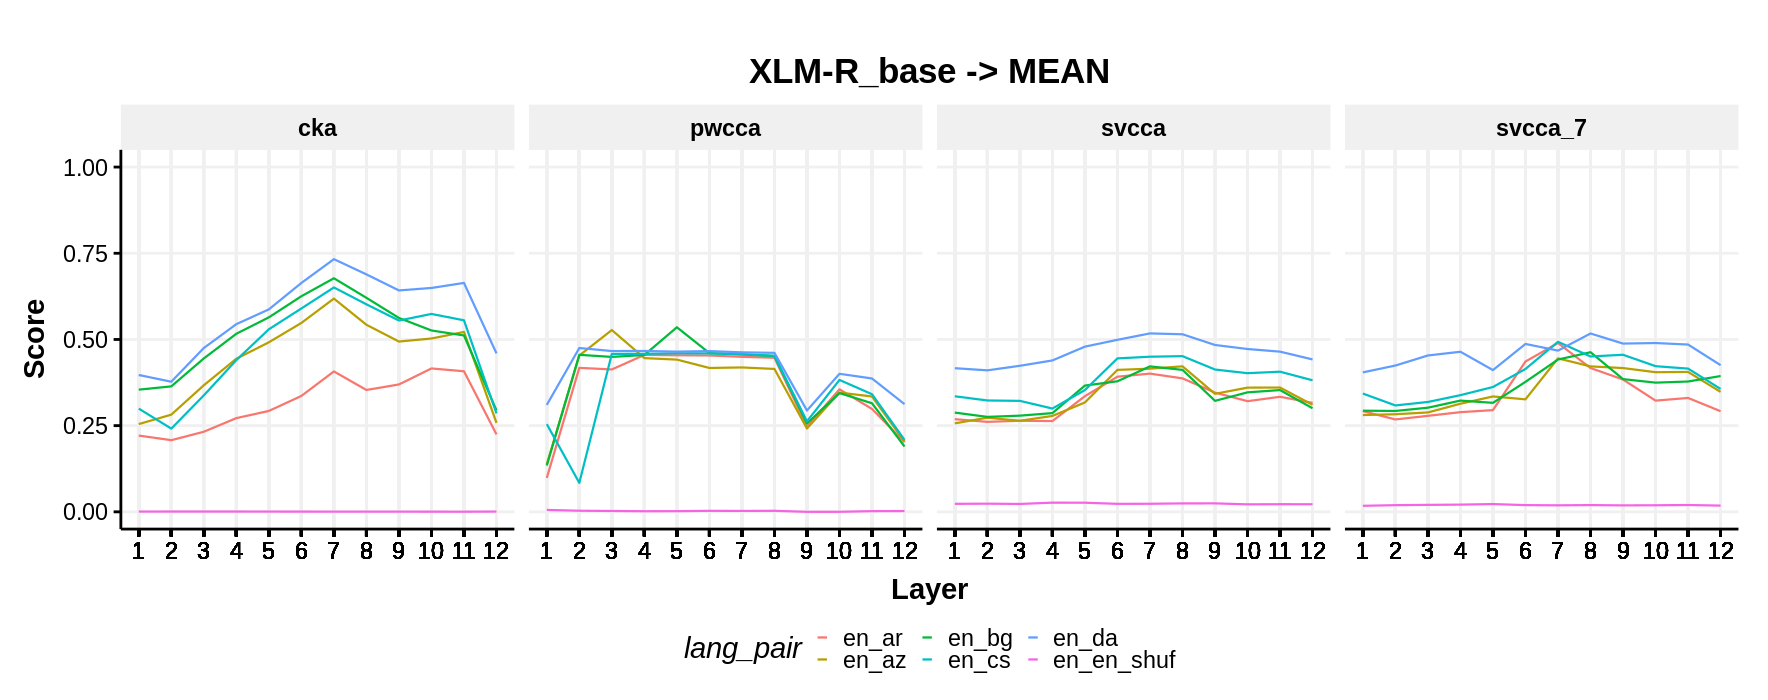

In [114]:
# GLOBALS
model_name_or_dir = "xlm-roberta-base"
data_type = "xnli6"
sent_rep_type = "mean"
sim_names = ["pwcca", "cka", "svcca", "svcca_7"]
lang_pairs = ["en-en_shuf", "en-ar", "en-az", "en-bg", "en-cs", "en-da"]
skip_0_layer = True
# load df

sim_scores_df = load_sim_scores_into_df(
    model_name_or_dir=model_name_or_dir, 
    data_type=data_type, 
    sim_names=sim_names, 
    sent_rep_type=sent_rep_type, 
    lang_pairs=lang_pairs)

# plot metrics data
with grdevices.render_to_bytesio(grdevices.png, width=1768, height=700, res=150) as img:
    title = f"{model_names_mapping[model_name_or_dir]} -> {sent_rep_type.upper()}"
    plot = ggplot2_plot_lines(sim_scores_df, title)
    plot = plot
    plot.plot()
display(Image(data=img.getvalue(), format='png', embed=True))

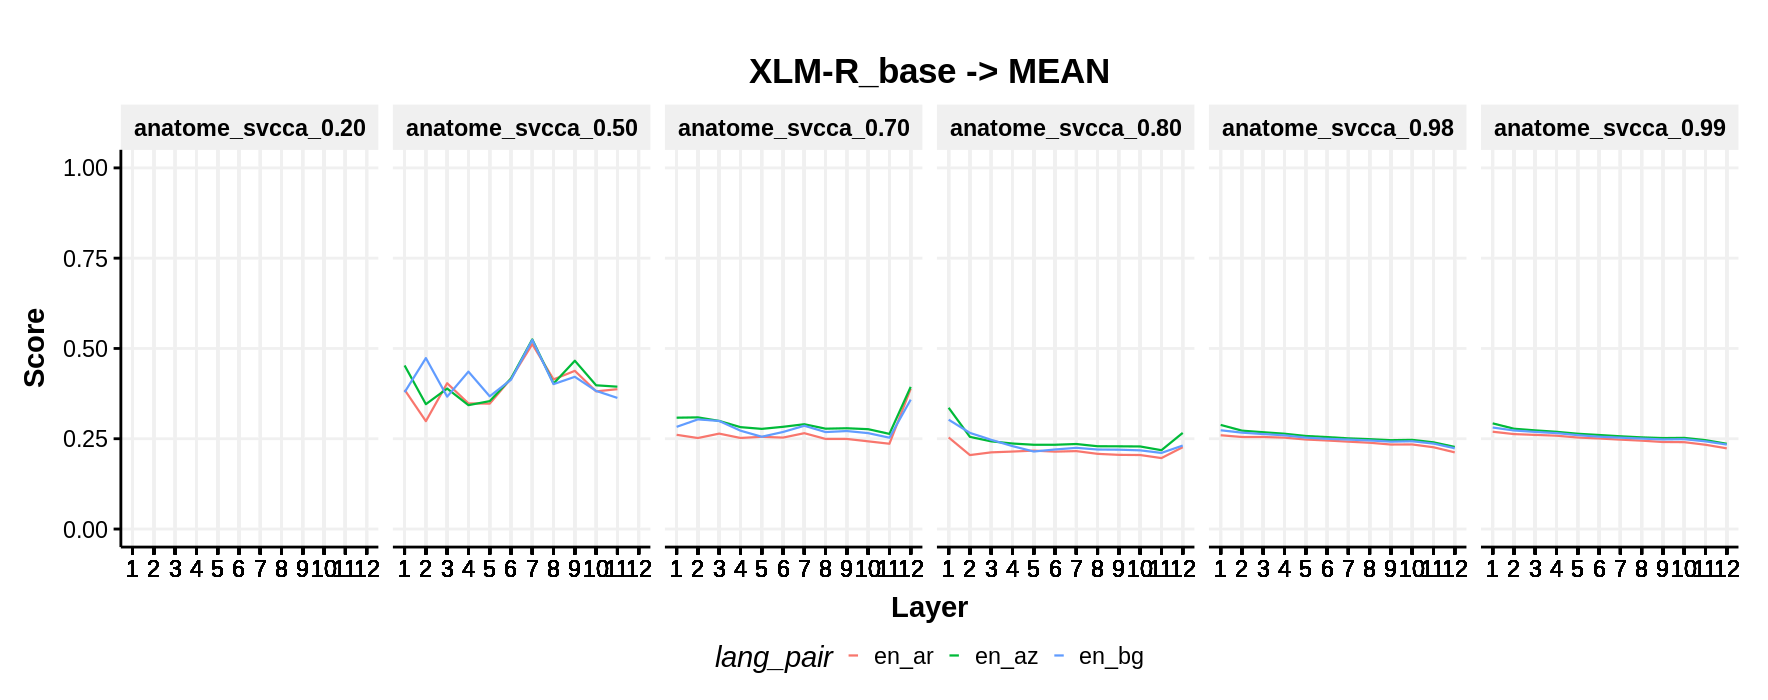

In [117]:
# GLOBALS
model_name_or_dir = "xlm-roberta-base"
data_type = "xnli6"
sent_rep_type = "mean"
sim_names = ["anatome_svcca_0.20", "anatome_svcca_0.50", "anatome_svcca_0.70", "anatome_svcca_0.80", "anatome_svcca_0.98", "anatome_svcca_0.99"]
# lang_pairs = ["en-en_shuf", "en-ar", "en-az", "en-bg", "en-cs", "en-da"]
lang_pairs = ["en-ar", "en-az", "en-bg"]

skip_0_layer = True
# load df

sim_scores_df = load_sim_scores_into_df(
    model_name_or_dir=model_name_or_dir, 
    data_type=data_type, 
    sim_names=sim_names, 
    sent_rep_type=sent_rep_type, 
    lang_pairs=lang_pairs)

# plot metrics data
with grdevices.render_to_bytesio(grdevices.png, width=1768, height=700, res=150) as img:
    title = f"{model_names_mapping[model_name_or_dir]} -> {sent_rep_type.upper()}"
    plot = ggplot2_plot_lines(sim_scores_df, title)
    plot = plot
    plot.plot()
display(Image(data=img.getvalue(), format='png', embed=True))

# Legacy

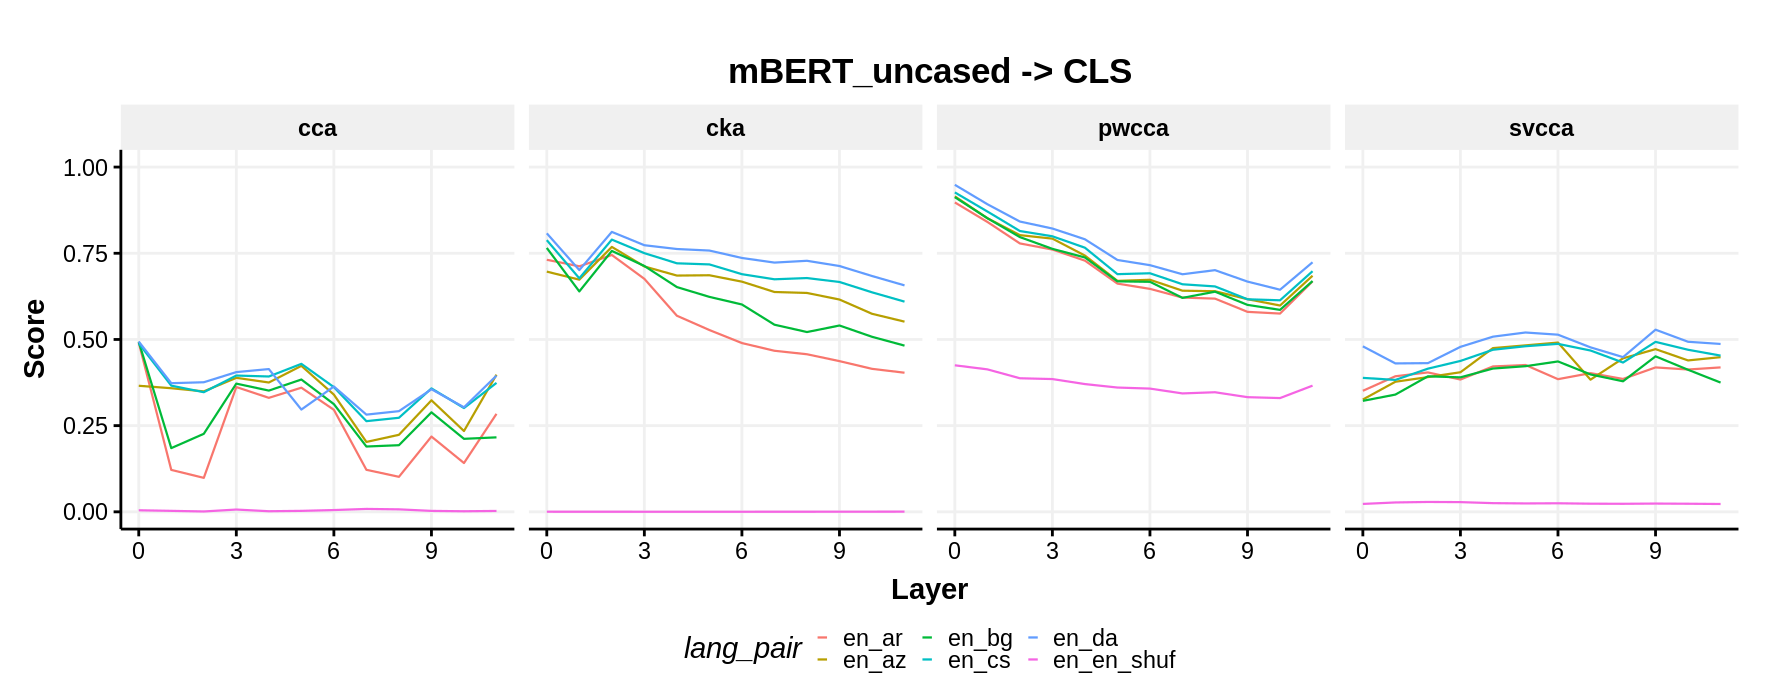

In [14]:
# GLOBALS
model_name_or_dir = "bert-base-multilingual-uncased"
data_type = "xnli6"
sent_rep_type = "cls"
sim_names = ["pwcca", "cca", "svcca", "cka"]
lang_pairs = ["en-en_shuf", "en-ar", "en-az", "en-bg", "en-cs", "en-da"]
skip_0_layer = True
# load df

sim_scores_df = load_sim_scores_into_df(
    model_name_or_dir=model_name_or_dir, 
    data_type=data_type, 
    sim_names=sim_names, 
    sent_rep_type=sent_rep_type, 
    lang_pairs=lang_pairs,
    skip_0_layer=skip_0_layer)

# plot metrics data
with grdevices.render_to_bytesio(grdevices.png, width=1768, height=700, res=150) as img:
    title = f"{model_names_mapping[model_name_or_dir]} -> {sent_rep_type.upper()}"
    plot = ggplot2_plot_lines(sim_scores_df, title)
    plot = plot
    plot.plot()
display(Image(data=img.getvalue(), format='png', embed=True))

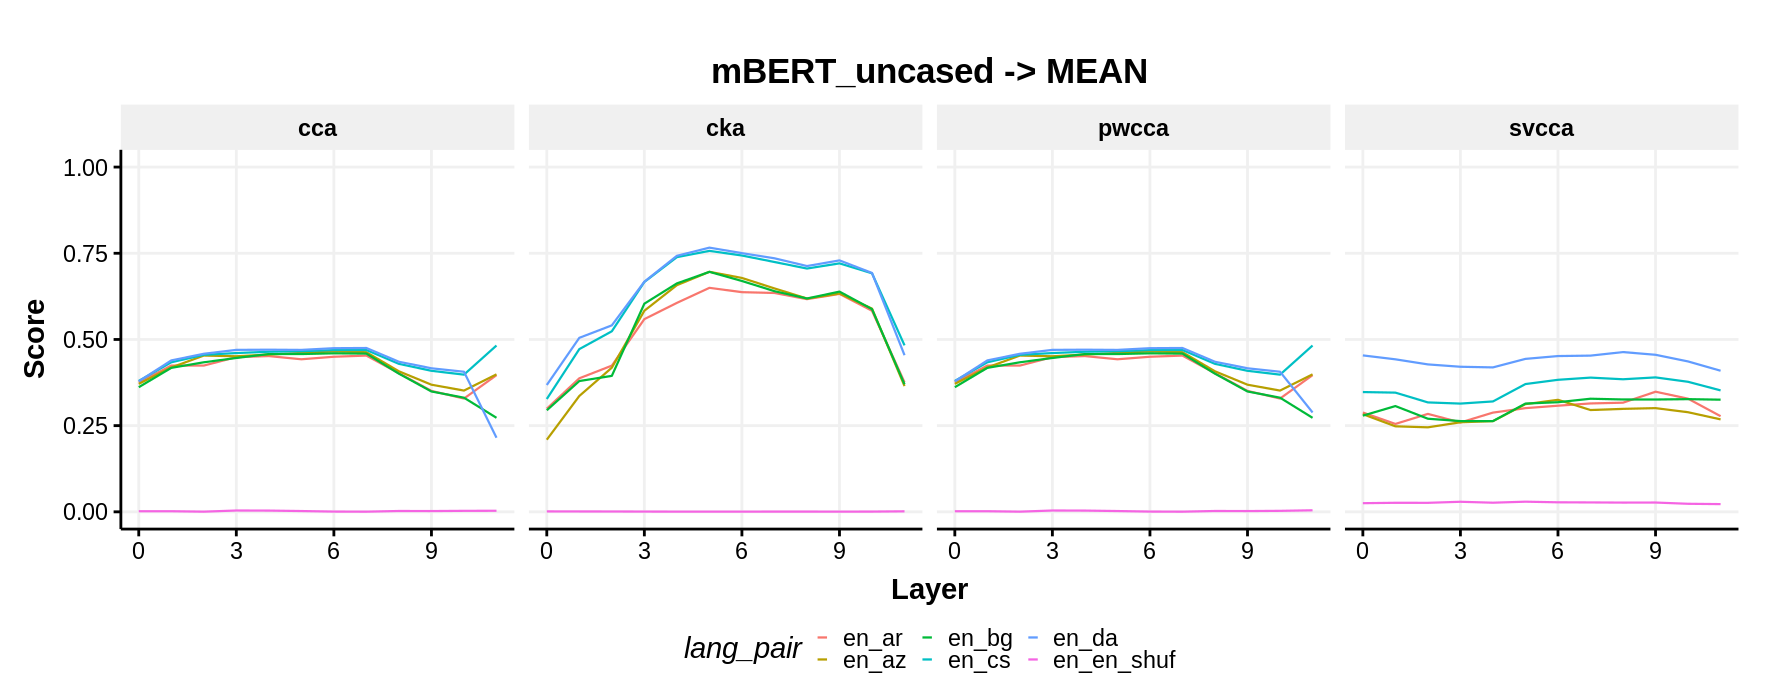

In [110]:
# GLOBALS
model_name_or_dir = "bert-base-multilingual-uncased"
data_type = "xnli6"
sent_rep_type = "mean"
sim_names = ["pwcca", "cca", "svcca", "cka"]
lang_pairs = ["en-en_shuf", "en-ar", "en-az", "en-bg", "en-cs", "en-da"]
skip_0_layer = True
# load df

sim_scores_df = load_sim_scores_into_df(
    model_name_or_dir=model_name_or_dir, 
    data_type=data_type, 
    sim_names=sim_names, 
    sent_rep_type=sent_rep_type, 
    lang_pairs=lang_pairs,
    skip_0_layer=skip_0_layer)

# plot metrics data
with grdevices.render_to_bytesio(grdevices.png, width=1768, height=700, res=150) as img:
    title = f"{model_names_mapping[model_name_or_dir]} -> {sent_rep_type.upper()}"
    plot = ggplot2_plot_lines(sim_scores_df, title)
    plot = plot
    plot.plot()
display(Image(data=img.getvalue(), format='png', embed=True))

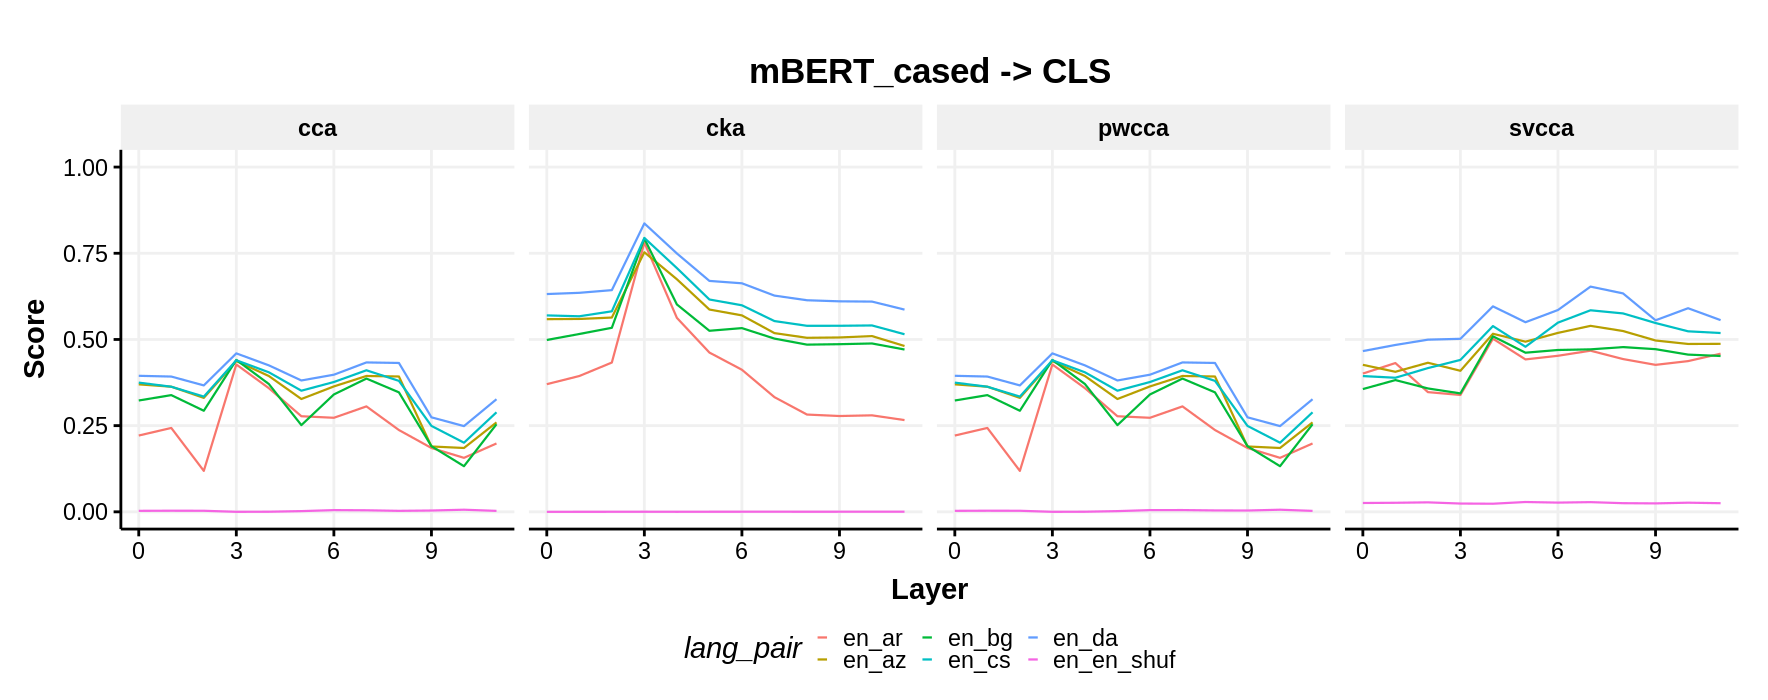

In [112]:
# GLOBALS
model_name_or_dir = "bert-base-multilingual-cased"
data_type = "xnli6"
sent_rep_type = "cls"
sim_names = ["pwcca", "cca", "svcca", "cka"]
lang_pairs = ["en-en_shuf", "en-ar", "en-az", "en-bg", "en-cs", "en-da"]
skip_0_layer = True
# load df

sim_scores_df = load_sim_scores_into_df(
    model_name_or_dir=model_name_or_dir, 
    data_type=data_type, 
    sim_names=sim_names, 
    sent_rep_type=sent_rep_type, 
    lang_pairs=lang_pairs,
    skip_0_layer=skip_0_layer)

# plot metrics data
with grdevices.render_to_bytesio(grdevices.png, width=1768, height=700, res=150) as img:
    title = f"{model_names_mapping[model_name_or_dir]} -> {sent_rep_type.upper()}"
    plot = ggplot2_plot_lines(sim_scores_df, title)
    plot = plot
    plot.plot()
display(Image(data=img.getvalue(), format='png', embed=True))

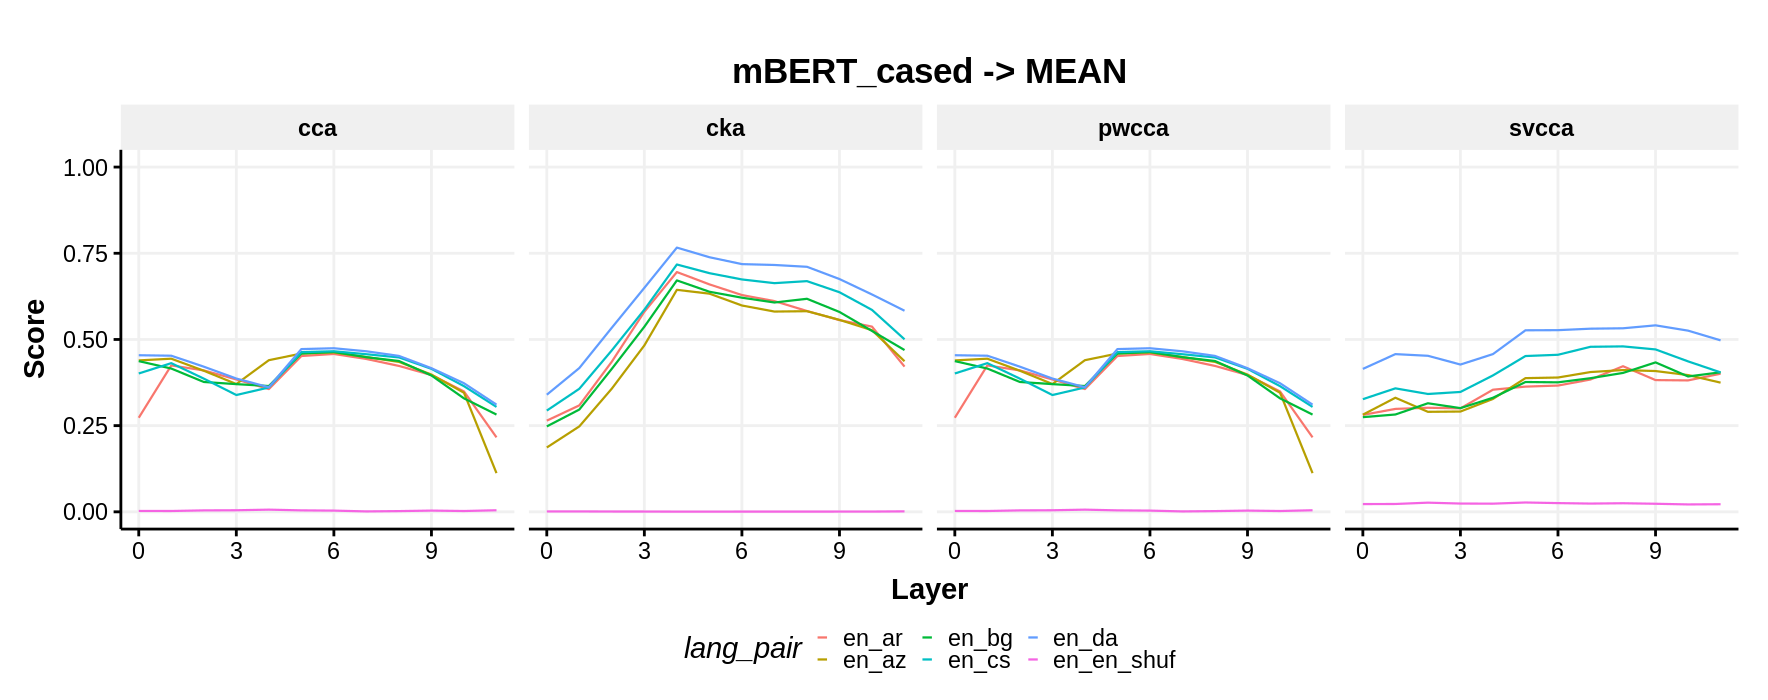

In [113]:
# GLOBALS
model_name_or_dir = "bert-base-multilingual-cased"
data_type = "xnli6"
sent_rep_type = "mean"
sim_names = ["pwcca", "cca", "svcca", "cka"]
lang_pairs = ["en-en_shuf", "en-ar", "en-az", "en-bg", "en-cs", "en-da"]
skip_0_layer = True
# load df

sim_scores_df = load_sim_scores_into_df(
    model_name_or_dir=model_name_or_dir, 
    data_type=data_type, 
    sim_names=sim_names, 
    sent_rep_type=sent_rep_type, 
    lang_pairs=lang_pairs,
    skip_0_layer=skip_0_layer)

# plot metrics data
with grdevices.render_to_bytesio(grdevices.png, width=1768, height=700, res=150) as img:
    title = f"{model_names_mapping[model_name_or_dir]} -> {sent_rep_type.upper()}"
    plot = ggplot2_plot_lines(sim_scores_df, title)
    plot = plot
    plot.plot()
display(Image(data=img.getvalue(), format='png', embed=True))

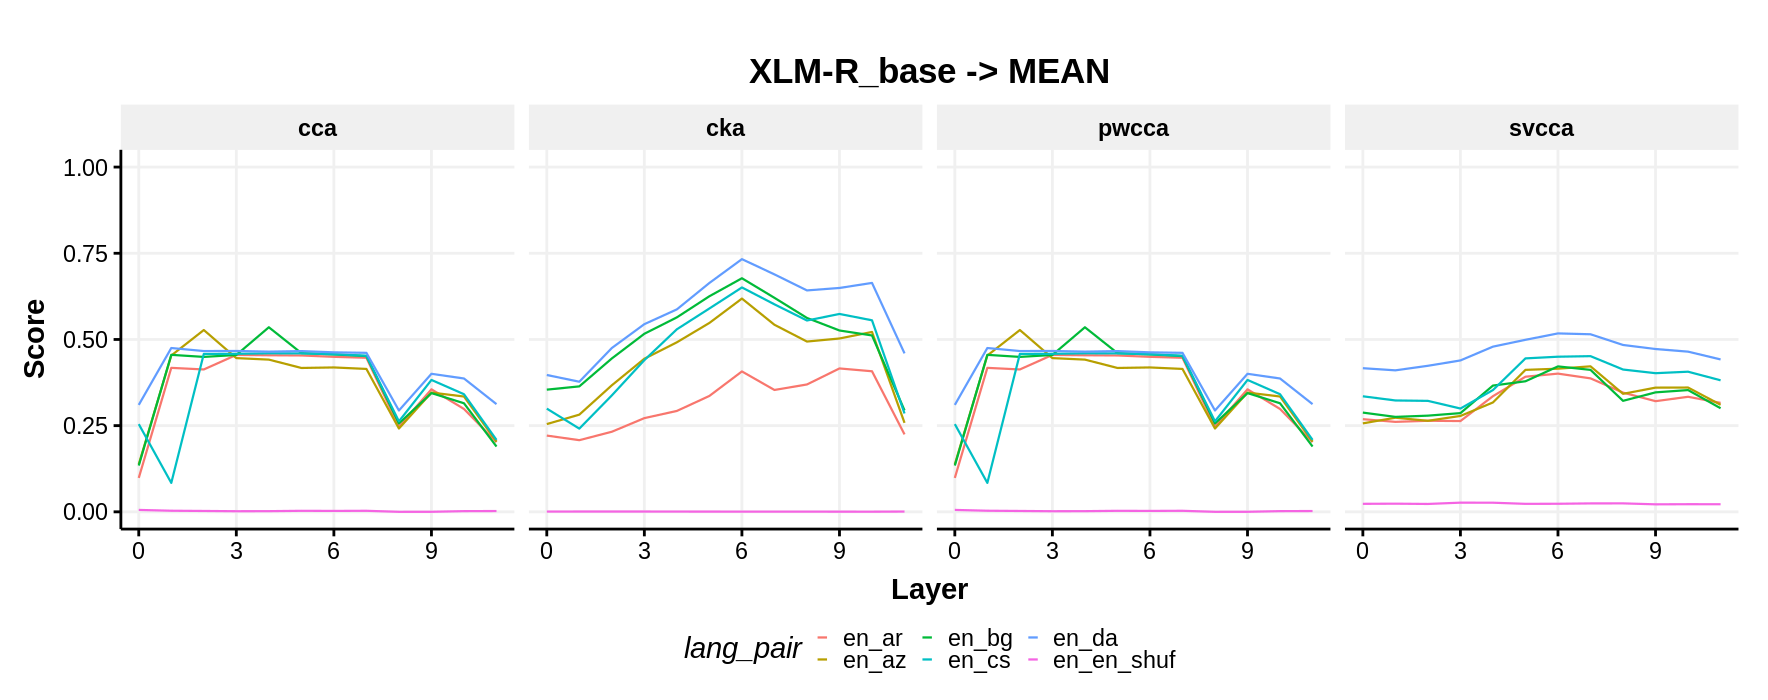

In [114]:
# GLOBALS
model_name_or_dir = "xlm-roberta-base"
data_type = "xnli6"
sent_rep_type = "mean"
sim_names = ["pwcca", "cca", "svcca", "cka"]
lang_pairs = ["en-en_shuf", "en-ar", "en-az", "en-bg", "en-cs", "en-da"]
skip_0_layer = True
# load df

sim_scores_df = load_sim_scores_into_df(
    model_name_or_dir=model_name_or_dir, 
    data_type=data_type, 
    sim_names=sim_names, 
    sent_rep_type=sent_rep_type, 
    lang_pairs=lang_pairs,
    skip_0_layer=skip_0_layer)

# plot metrics data
with grdevices.render_to_bytesio(grdevices.png, width=1768, height=700, res=150) as img:
    title = f"{model_names_mapping[model_name_or_dir]} -> {sent_rep_type.upper()}"
    plot = ggplot2_plot_lines(sim_scores_df, title)
    plot = plot
    plot.plot()
display(Image(data=img.getvalue(), format='png', embed=True))

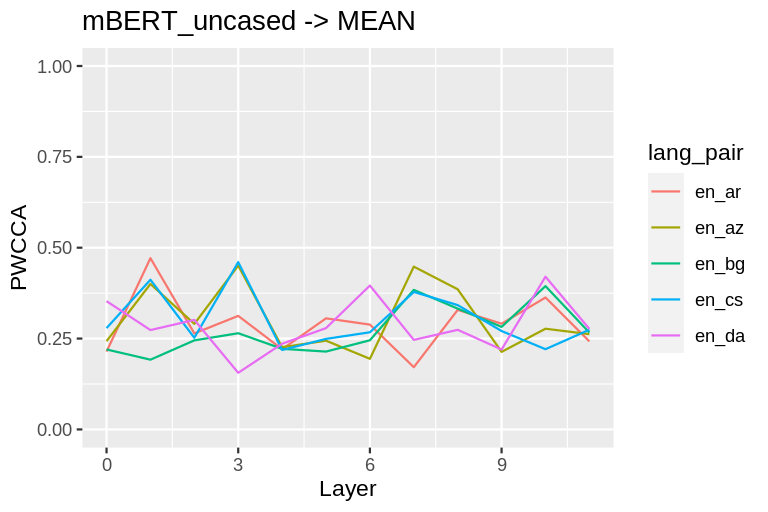

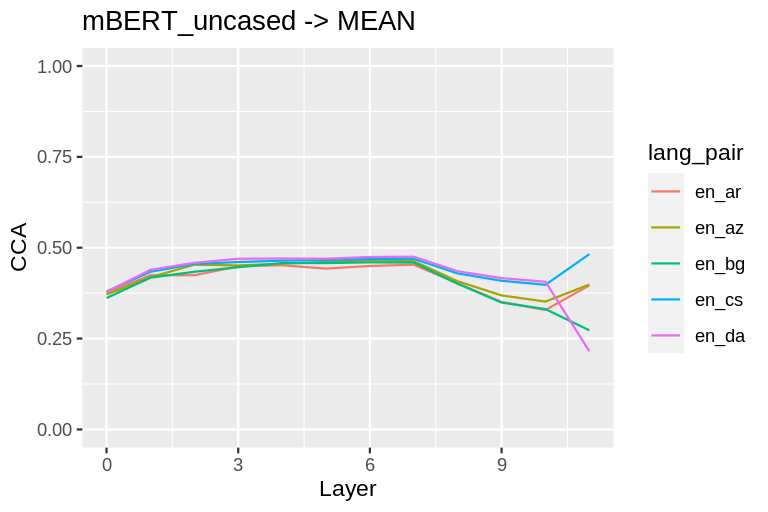

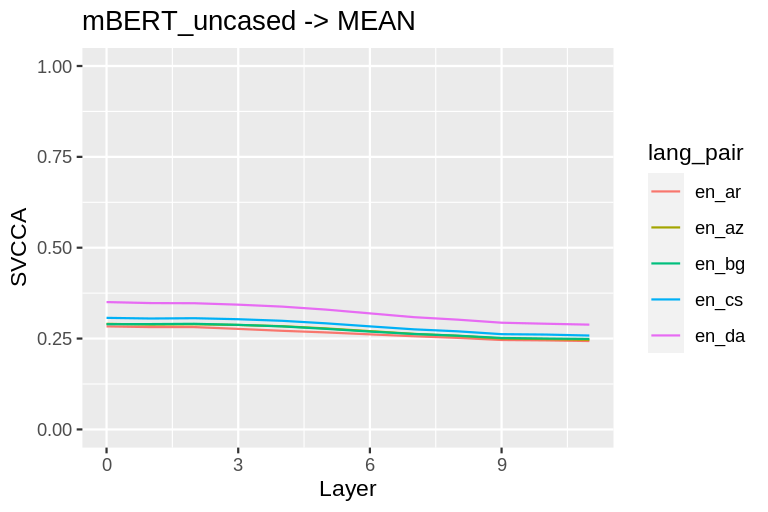

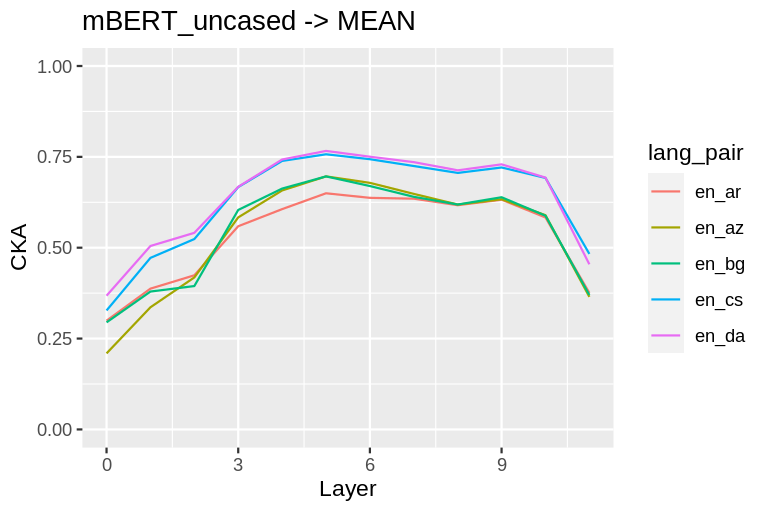

In [22]:
for sent_rep_type in ["mean"]:
    for model_name_or_dir in ["bert-base-multilingual-uncased"]:
        loaddir = f"{savedir_base}/{model_name_or_dir}/sim_scores"
        for sim_name in sim_names:
            loadfile_path = f"{loaddir}/xnli6_{sim_name}_{sent_rep_type}.pkl"

            sim_scores = pickle_load_from_file(loadfile_path, verbose=False)

            title = f"{model_names_mapping[model_name_or_dir]} -> {sent_rep_type.upper()}"
            ggplot2_plot_lines(sim_scores, title, sim_name.upper())            

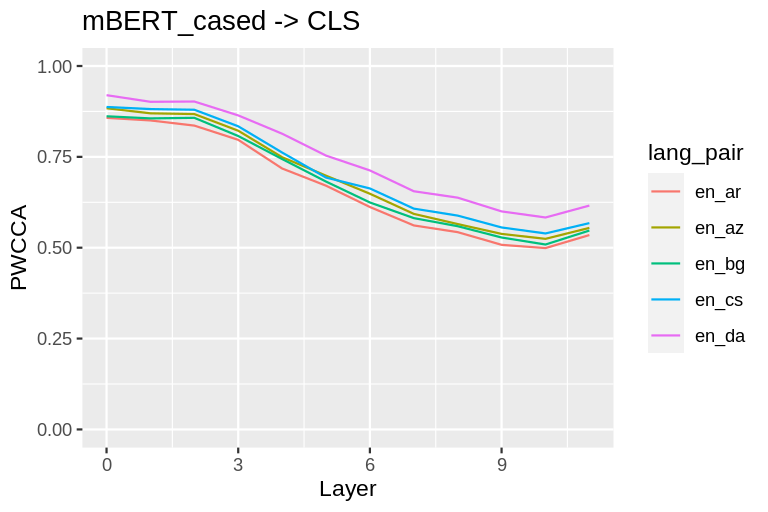

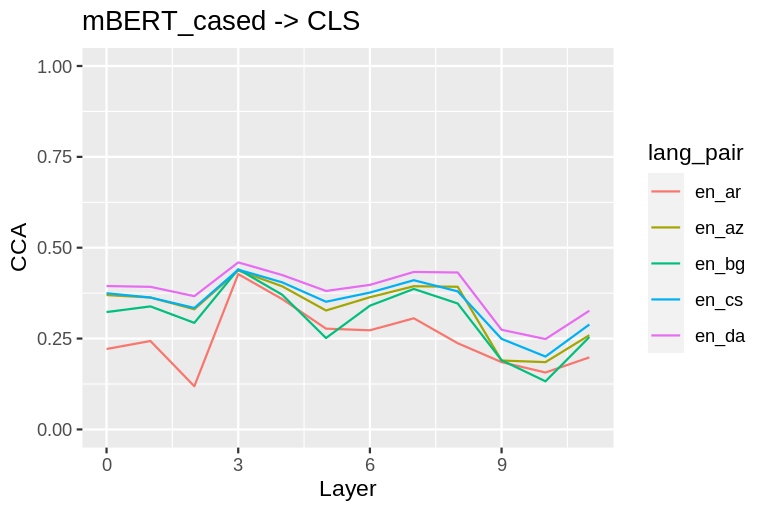

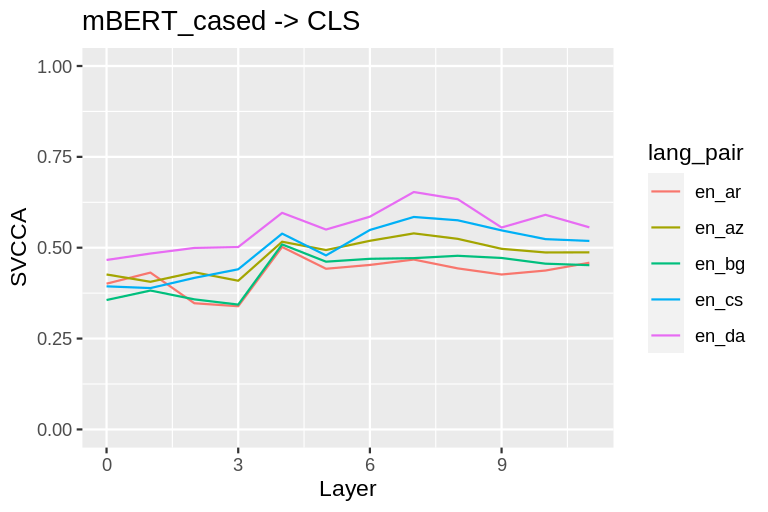

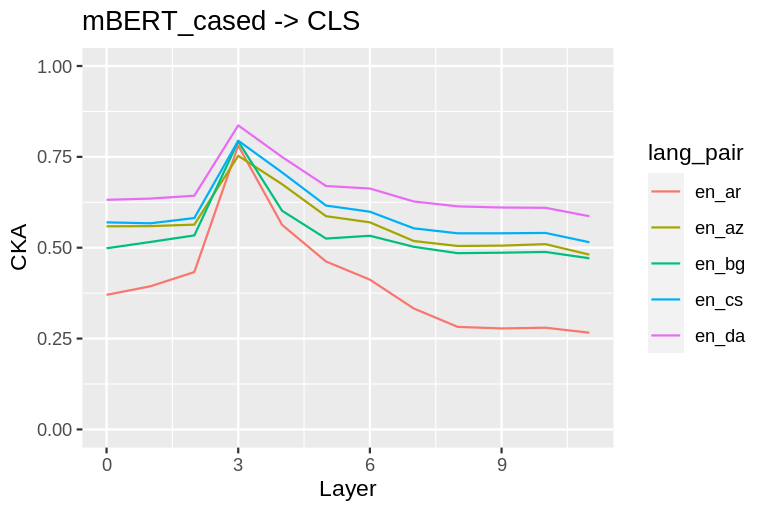

In [23]:
for sent_rep_type in ["cls"]:
    for model_name_or_dir in ["bert-base-multilingual-cased"]:
        loaddir = f"{savedir_base}/{model_name_or_dir}/sim_scores"
        for sim_name in sim_names:
            loadfile_path = f"{loaddir}/xnli6_{sim_name}_{sent_rep_type}.pkl"

            sim_scores = pickle_load_from_file(loadfile_path, verbose=False)

            title = f"{model_names_mapping[model_name_or_dir]} -> {sent_rep_type.upper()}"
            ggplot2_plot_lines(sim_scores, title, sim_name.upper())            

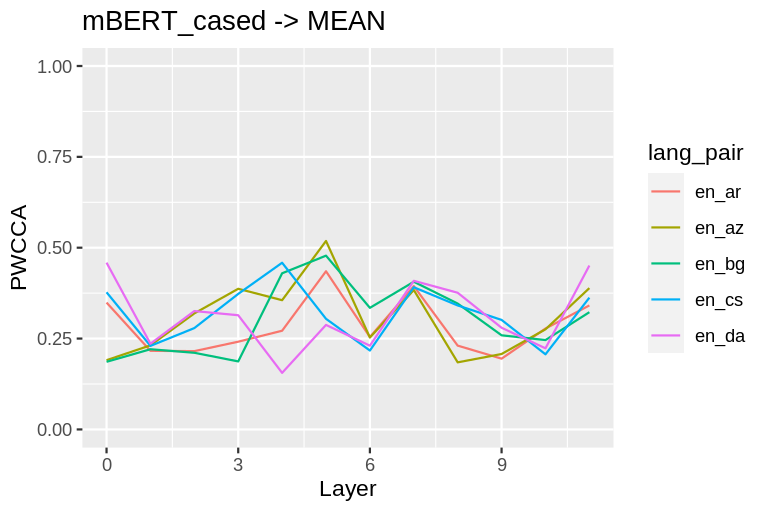

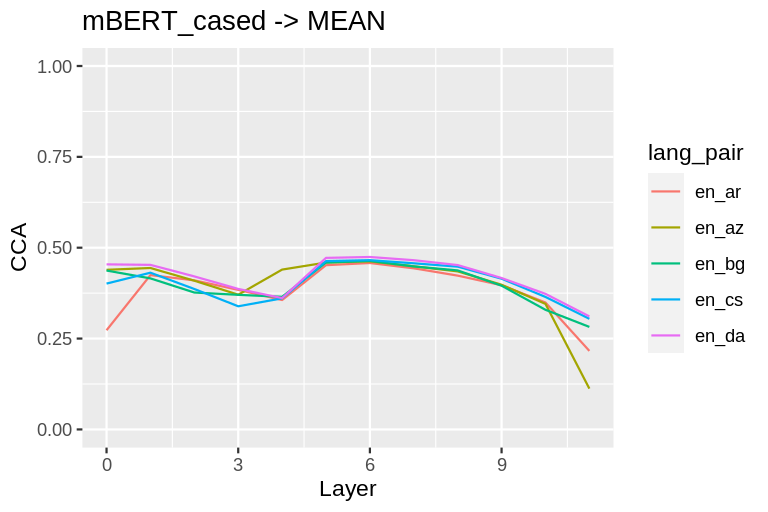

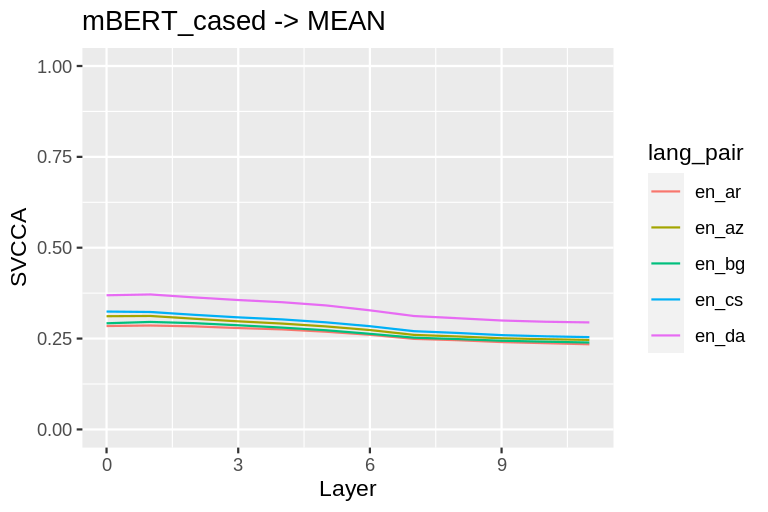

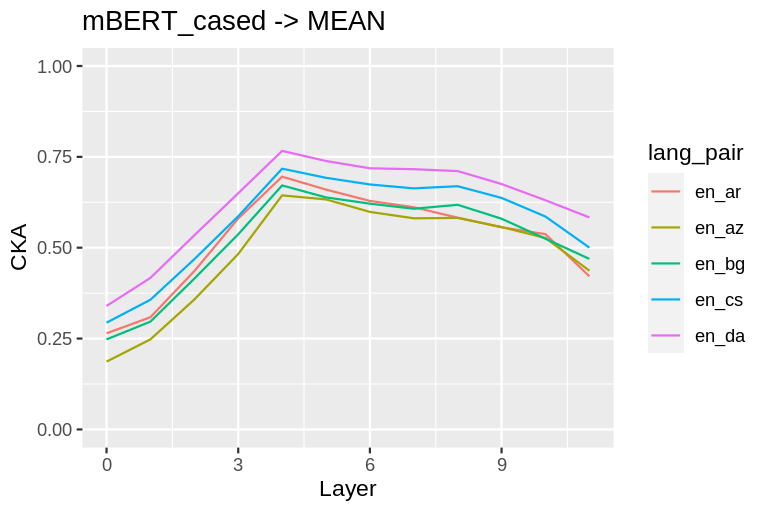

In [24]:
for sent_rep_type in ["mean"]:
    for model_name_or_dir in ["bert-base-multilingual-cased"]:
        loaddir = f"{savedir_base}/{model_name_or_dir}/sim_scores"
        for sim_name in sim_names:
            loadfile_path = f"{loaddir}/xnli6_{sim_name}_{sent_rep_type}.pkl"

            sim_scores = pickle_load_from_file(loadfile_path, verbose=False)

            title = f"{model_names_mapping[model_name_or_dir]} -> {sent_rep_type.upper()}"
            ggplot2_plot_lines(sim_scores, title, sim_name.upper())            

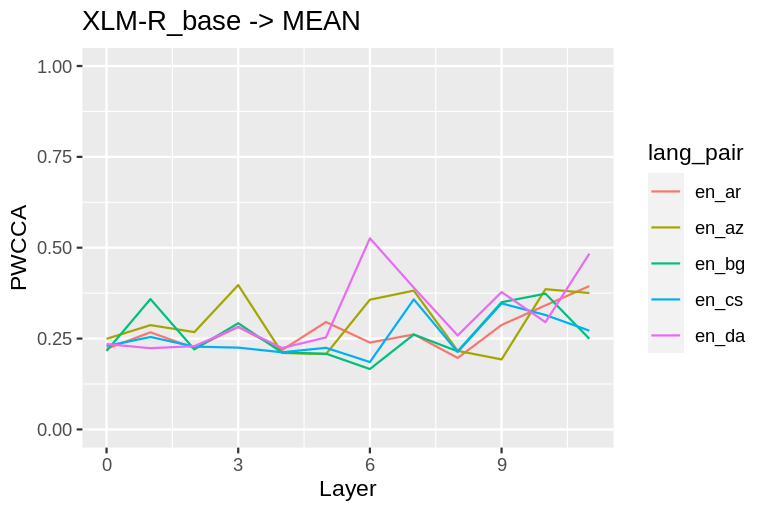

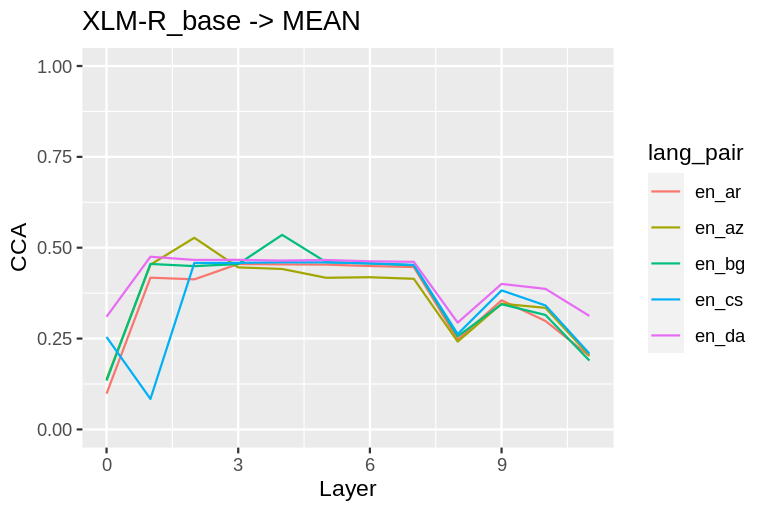

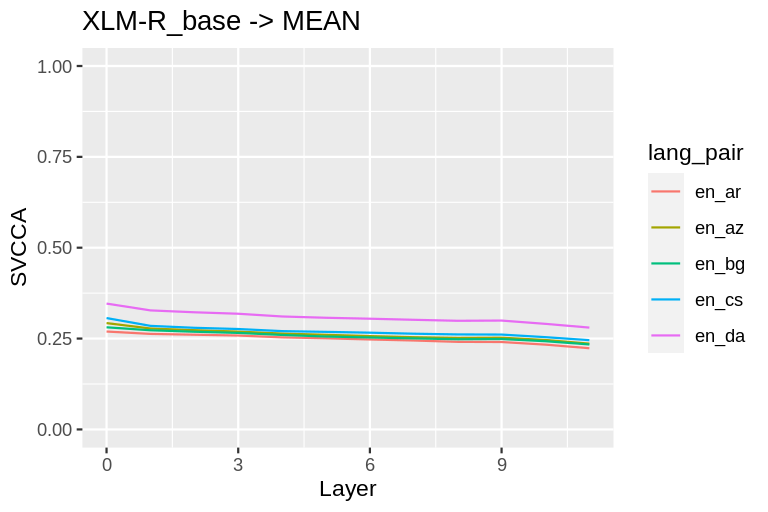

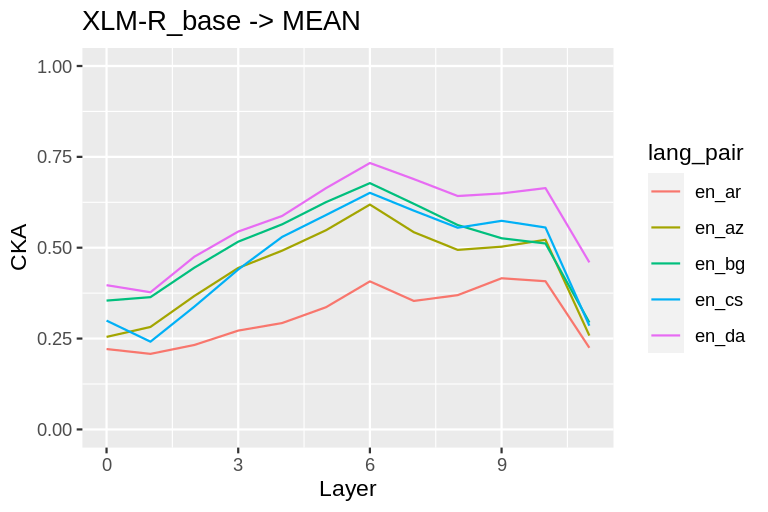

In [25]:
for sent_rep_type in ["mean"]:
    for model_name_or_dir in ["xlm-roberta-base"]:
        loaddir = f"{savedir_base}/{model_name_or_dir}/sim_scores"
        for sim_name in sim_names:
            loadfile_path = f"{loaddir}/xnli6_{sim_name}_{sent_rep_type}.pkl"

            sim_scores = pickle_load_from_file(loadfile_path, verbose=False)

            title = f"{model_names_mapping[model_name_or_dir]} -> {sent_rep_type.upper()}"
            ggplot2_plot_lines(sim_scores, title, sim_name.upper())            